# VGGNet


모든 커널이 3*3을 사용하면 3X3을 2번 사용하는 것이 5X5보다 더 연산량을 줄일 뿐 아니라 Receptive field를 넓힐 수 있다.

## 실습 목표
-----
- VGGNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- Pre-training 모델의 사용방법을 이해한다.

## 문제 정의
----
- VGGNet 구조 살펴보기



![VGG](https://miro.medium.com/max/1100/0*6VP81rFoLWp10FcG)

## 주요 코드
----



### 1. VGGNet

```
# Model
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 360),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(360, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    # 'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

```

# 2. Pretrained model-transfer learning(전이학습)

```
from torchvision import models

vgg16 = models.vgg16(pretrained=True)
vgg16.to(DEVICE)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.classifier.parameters(), lr = LEARNING_RATE, momentum=0.9)
```

## CIFAR Classifier(VGGNet)
----
CIFAR 데이터셋을 사용하여 이미지에 포함된 object가 무엇인지 분류하는 이미지 분류기를 생성해봅니다.


### [Step1] Load libraries & Datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image



### [Step2] Data preprocessing

불러온 이미지의 증강을 통해 학습 정확도를 향상시키도록 합니다.

* RandomCrop
* RandomHorizontalFlip
* Normalize

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((256, 256)), size가 너무커서 연산량의 증가로 중간에 짤림
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),   
])

train_img = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform,
)

test_img = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### [Step3] Set hyperparameters

In [3]:
EPOCH = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


### [Step4] Create DataLoader

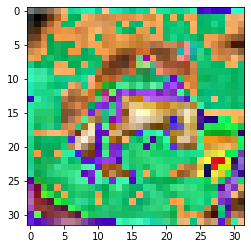

In [4]:
train_loader = DataLoader(train_img, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_img, batch_size = BATCH_SIZE, shuffle = False)
next(iter(train_img))[0].size()

plt.imshow(to_pil_image(next(iter(train_img))[0]))

### [Step5] Set Network Structure

In [5]:
# Model
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 360),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(360, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0),-1)      
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)


### [Step6] Create Model instance

In [6]:
model = VGG('VGG11').to(DEVICE)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### [Step7] Model compile

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9)

### [Step8] Set train loop

In [8]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    
    size = len(train_loader.dataset)
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        
        # 손실 계산
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}]/{size:5d}')

### [Step9] Set test loop

In [9]:
def test(test_loader, model, loss_fn):
    model.eval()

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f}\n")

### [Step10] Run model

In [10]:
for i in range(EPOCH) :
    print(f"Epoch {i+1} \n------------------------")
    train(train_loader, model, loss, optimizer)
    test(test_loader, model, loss)
print("Done!")

Epoch 1 
------------------------
loss: 2.333146  [    0]/50000
loss: 2.275612  [ 3200]/50000
loss: 1.836070  [ 6400]/50000
loss: 1.484531  [ 9600]/50000
loss: 1.696527  [12800]/50000
loss: 1.611766  [16000]/50000
loss: 1.474290  [19200]/50000
loss: 1.568979  [22400]/50000
loss: 1.439251  [25600]/50000
loss: 1.154566  [28800]/50000
loss: 1.099559  [32000]/50000
loss: 1.011435  [35200]/50000
loss: 1.520515  [38400]/50000
loss: 1.552706  [41600]/50000
loss: 0.848125  [44800]/50000
loss: 1.422965  [48000]/50000
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.198098

Epoch 2 
------------------------
loss: 1.207134  [    0]/50000
loss: 1.041743  [ 3200]/50000
loss: 1.184370  [ 6400]/50000
loss: 1.146663  [ 9600]/50000
loss: 0.877007  [12800]/50000
loss: 1.103694  [16000]/50000
loss: 1.029794  [19200]/50000
loss: 1.061754  [22400]/50000
loss: 0.955182  [25600]/50000
loss: 0.910905  [28800]/50000
loss: 1.059166  [32000]/50000
loss: 1.367384  [35200]/50000
loss: 1.017369  [38400]/50000
loss: 0.701

## CIFAR Classifier(Pretrained VGGNet)
----
ImageNet 데이터로 학습한 VGGNet을 사용하여 주어진 데이터 셋에서 사용할 수 있도록 Fine tuning 해봅니다.


In [11]:
from torchvision import models

vgg16 = models.vgg11(pretrained=True) # 학습된 parameter도 가져오기 위해 pretrain을 True로 설정
vgg16.to(DEVICE)
print(vgg16)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [12]:
vgg16.classifier[6].out_features = 10

for param in vgg16.features.parameters():
    param.requires_grad = False    

In [13]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.classifier.parameters(), lr = LEARNING_RATE, momentum=0.9)

In [15]:
for i in range(EPOCH) :
    print(f"Epoch {i+1} \n------------------------")
    train(train_loader, vgg16, loss, optimizer)
    test(test_loader, vgg16, loss)
print("Done!")

Epoch 1 
------------------------
loss: 19.361952  [    0]/50000
loss: 2.099538  [ 3200]/50000
loss: 1.340372  [ 6400]/50000
loss: 1.525899  [ 9600]/50000
loss: 1.392601  [12800]/50000
loss: 1.301946  [16000]/50000
loss: 1.196849  [19200]/50000
loss: 1.196187  [22400]/50000
loss: 1.470780  [25600]/50000
loss: 0.972796  [28800]/50000
loss: 1.288711  [32000]/50000
loss: 1.177235  [35200]/50000
loss: 0.738617  [38400]/50000
loss: 1.467105  [41600]/50000
loss: 1.003472  [44800]/50000
loss: 0.984008  [48000]/50000
Test Error: 
 Accuracy: 63.5%, Avg loss: 1.052547

Epoch 2 
------------------------
loss: 1.128007  [    0]/50000
loss: 0.861613  [ 3200]/50000
loss: 1.252751  [ 6400]/50000
loss: 1.060045  [ 9600]/50000
loss: 1.122589  [12800]/50000
loss: 0.881412  [16000]/50000
loss: 0.814456  [19200]/50000
loss: 0.675744  [22400]/50000
loss: 0.887268  [25600]/50000
loss: 0.979785  [28800]/50000
loss: 0.912370  [32000]/50000
loss: 1.176403  [35200]/50000
loss: 1.045272  [38400]/50000
loss: 0.98